<center>
<img
src="https://i.ibb.co/th5MTcv/logo.png" width="800" 
     />
</center>

## Orbit equation for a test particle in a Schwarzschild background.

The differential equation for the orbit of a particle moving under Newtonian gravity is obtained from the Lagrangian describing the system. This equation relates the radial coordinate $r$ with the angular coordinate $\phi$ in the orbital plane. Usually, the differential equation is written in terms of the auxiliary variable $u=\frac{1}{r}$ as

\begin{equation}
\frac{d^2 u}{d\varphi^2} = - u +\frac{M}{\ell^2} + 3Mu^2
\end{equation}

where we have identified the conserved orbital angular momentum : $\ell = p_\phi$.

An important consideration has to do with the magnitudes of the physical quantities and constants involved in the problem. For the development, we will use the following system of units:

- Units of mass: Solar Masses $M_{\odot}$
- Distance units: astronomical units [au]
- Time units: years [yr]

In this system of units, the Newtonian gravitational constant takes the value $G = 4\pi^2$.

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Loading data and definition of the training points

Total available data :  (1000000, 2)
Training points:  torch.Size([10, 1]) torch.Size([10, 1])


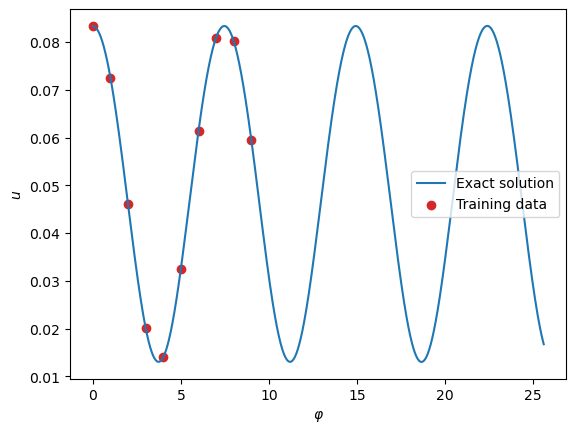

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Saves GIF file from image files"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


y = np.loadtxt('Schwarzschild_orbit.txt')
print('Total available data : ',y.shape)
phi = torch.from_numpy(y[:640000:10,0]).view(-1,1).to(torch.float32)
u = torch.from_numpy(y[:640000:10,1]).view(-1,1).to(torch.float32)

# slice out a small number of points (10) from the domain
phi_data = phi[0:25000:2500]
u_data = u[0:25000:2500]
print('Training points: ',phi_data.shape, u_data.shape)

# Plot of the exact solution
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.show()


### Training the Deep Neural Network using only data from the known solution.

In [3]:
class DNN(nn.Module):
    """
    Defines a connected network
    ============================================================================
    N_INPUT: number of input variables
    N_OUTPUT: number of output variables
    N_HIDDEN: number of units per hidden layer
    N_LAYERS: number of hidden layers
    ============================================================================
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # The tanh activation restricts output to [-1, 1] 
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        #self.dropout = nn.Dropout(p=0.3)
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    #plt.scatter(x0, y0, s=60, color="tab:red", alpha=0.4, label='Initial Condition')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 30)
    plt.ylim(0, 0.1)
    plt.text(30.,0.01,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

Epoch:  100  Loss:  0.00019936244643758982
Epoch:  200  Loss:  0.00012565756333060563
Epoch:  300  Loss:  0.00010633670899551362
Epoch:  400  Loss:  9.631850844016299e-05
Epoch:  500  Loss:  8.645156776765361e-05
Epoch:  600  Loss:  7.534468022640795e-05
Epoch:  700  Loss:  6.0200585721759126e-05
Epoch:  800  Loss:  3.822112921625376e-05
Epoch:  900  Loss:  2.610125193314161e-05
Epoch:  1000  Loss:  2.2961035938351415e-05


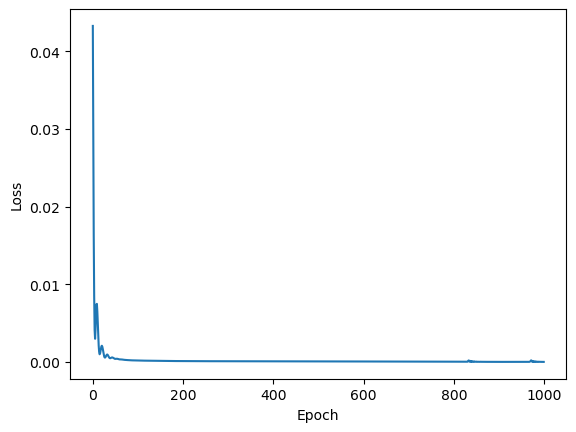

In [21]:

# Train the standard neural network to fit the training data

epochs = 1000

torch.manual_seed(413)
model = DNN(1,1,32,5) # 1 input, 1 output, 32 neurons in 5 hidden layers
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []

for i in range(1000):
    optimizer.zero_grad()
    u_pred = model(phi_data)
    loss = torch.mean((u_pred-u_data)**2) # mean squared error
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


    # Save plots of the training
    if (i+1) % 10 == 0:
        u_pred = model(phi).detach()
        plot_result(phi,u,phi_data,u_data,u_pred)
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        plt.close()

        #if (i+1) % 500 == 0: plt.show()
        #else: plt.close("all")

    if (i+1) %100 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("nn.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Definition of the PINN and training using data from the differential equation, the initial condition and some known data from the exact solution.

In [5]:
def ODE(model, x):
    """
    ODE of the orbit in Newtonian gravity.
    """

    y = model(x)
    # computes dy/dx
    dydx  = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    # computes d^2y/dx^2
    dydx2 = torch.autograd.grad(dydx,  x, torch.ones_like(dydx),  create_graph=True)[0]
    # computes the differential equation
    ode = dydx2 + y - M/L**2 - 3*M*y**2
    return ode

Epoch:  500  Loss:  6.955384742468596e-05
Epoch:  1000  Loss:  4.202254785923287e-05
Epoch:  1500  Loss:  3.0256149329943582e-05
Epoch:  2000  Loss:  2.7299545763526112e-05
Epoch:  2500  Loss:  2.311841853952501e-05
Epoch:  3000  Loss:  3.0377424991456792e-05
Epoch:  3500  Loss:  1.9534918465069495e-05
Epoch:  4000  Loss:  0.0001275160175282508
Epoch:  4500  Loss:  1.9564626200008206e-05
Epoch:  5000  Loss:  1.687268741079606e-05
Epoch:  5500  Loss:  6.984210631344467e-05
Epoch:  6000  Loss:  1.6446141671622172e-05
Epoch:  6500  Loss:  1.4927589290891774e-05
Epoch:  7000  Loss:  1.613484346307814e-05
Epoch:  7500  Loss:  1.4354975974129047e-05
Epoch:  8000  Loss:  1.556231472932268e-05
Epoch:  8500  Loss:  1.372526639897842e-05
Epoch:  9000  Loss:  1.4529723557643592e-05
Epoch:  9500  Loss:  1.326103119936306e-05
Epoch:  10000  Loss:  1.4912824553903192e-05
Epoch:  10500  Loss:  1.2831324056605808e-05
Epoch:  11000  Loss:  1.609166974958498e-05
Epoch:  11500  Loss:  1.2234191672177985e

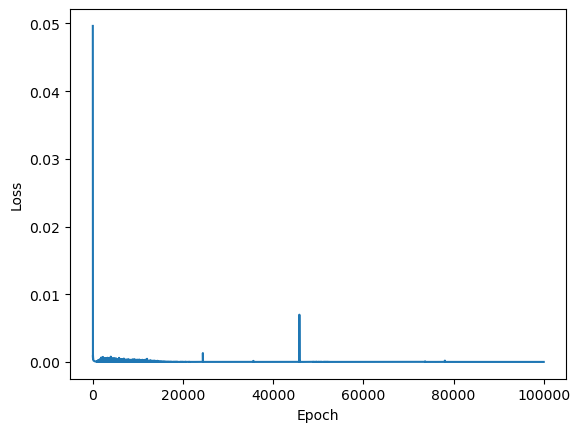

In [24]:




# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5


epochs = 100000
torch.manual_seed(413)
model = DNN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel = model
bestLoss = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data)
    loss1 = torch.mean((u_pred - u_data)**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-1)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = model

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data,u_data,u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn1.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Best loss:  4.685786869629283e-09


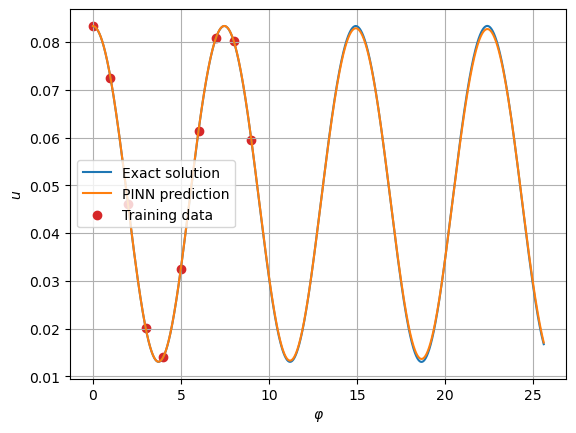

In [25]:
print('Best loss: ', bestLoss)

# Plot the final result
u_pred = bestModel(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


### Definition of the PINN and training using data from the differential equation and less data.

Epoch:  500  Loss:  5.553902155952528e-05
Epoch:  1000  Loss:  3.0060004064580426e-05
Epoch:  1500  Loss:  2.4742143068579026e-05
Epoch:  2000  Loss:  1.89237453014357e-05
Epoch:  2500  Loss:  1.6686613889760338e-05
Epoch:  3000  Loss:  1.6082309230114333e-05
Epoch:  3500  Loss:  1.5380046534119174e-05
Epoch:  4000  Loss:  1.5202707800199278e-05
Epoch:  4500  Loss:  1.8133972844225354e-05
Epoch:  5000  Loss:  1.4660082342743408e-05
Epoch:  5500  Loss:  1.5646459360141307e-05
Epoch:  6000  Loss:  1.4260060197557323e-05
Epoch:  6500  Loss:  1.8493765310267918e-05
Epoch:  7000  Loss:  1.3840908650308847e-05
Epoch:  7500  Loss:  1.413209338352317e-05
Epoch:  8000  Loss:  1.344288102700375e-05
Epoch:  8500  Loss:  1.3489370758179575e-05
Epoch:  9000  Loss:  1.3147818208381068e-05
Epoch:  9500  Loss:  1.3178420886106323e-05
Epoch:  10000  Loss:  1.526070263935253e-05
Epoch:  10500  Loss:  1.2836859241360798e-05
Epoch:  11000  Loss:  4.6255707275122404e-05
Epoch:  11500  Loss:  1.252377660421

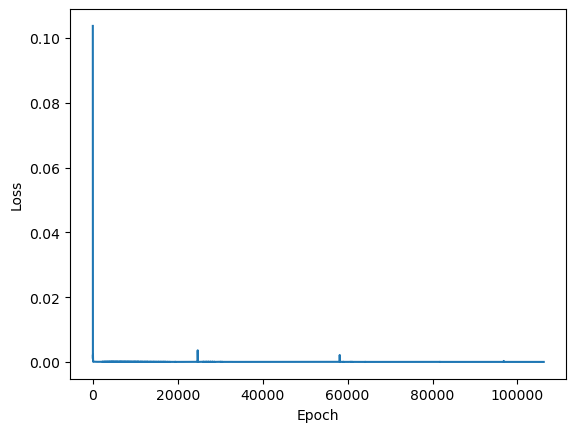

In [33]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5


epochs = 160000
torch.manual_seed(413)
model = DNN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel2 = model
bestLoss2 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data[:6])
    loss1 = torch.mean((u_pred - u_data[:6])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss2:
        bestLoss2 = loss.item()
        bestModel2 = model
    if loss.item() < 2e-9: break

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data[:6],u_data[:6],u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Best loss:  1.9994916833354637e-09


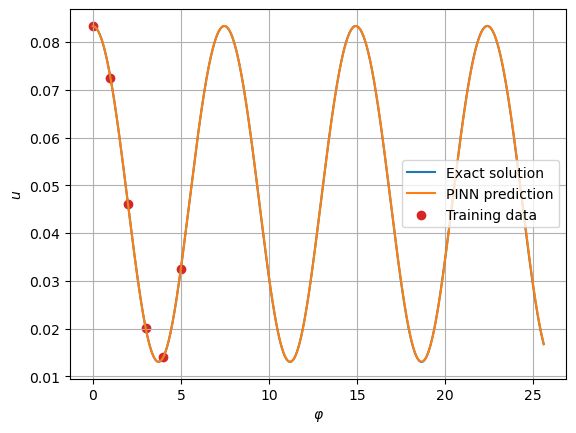

In [34]:
print('Best loss: ', bestLoss2)

# Plot the final result
u_pred = bestModel2(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data[:6], u_data[:6], color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


### Definition of the PINN and training using data from the differential equation and the initial condition.

Epoch:  500  Loss:  2.8332397050689906e-07
Epoch:  1000  Loss:  2.336765163590826e-07
Epoch:  1500  Loss:  2.0004074485768797e-07
Epoch:  2000  Loss:  1.7809426822168462e-07
Epoch:  2500  Loss:  1.646830298795976e-07
Epoch:  3000  Loss:  1.5447868406681664e-07
Epoch:  3500  Loss:  1.4338004916680802e-07
Epoch:  4000  Loss:  1.463902776777104e-07
Epoch:  4500  Loss:  1.4418202454180573e-07
Epoch:  5000  Loss:  1.5607371040005091e-07
Epoch:  5500  Loss:  1.4920566115961265e-07
Epoch:  6000  Loss:  1.4605049614146992e-07
Epoch:  6500  Loss:  1.5576628697999695e-07
Epoch:  7000  Loss:  1.4550694515946816e-07
Epoch:  7500  Loss:  1.5389952068289858e-07
Epoch:  8000  Loss:  1.425102027496905e-07
Epoch:  8500  Loss:  1.499790727166328e-07
Epoch:  9000  Loss:  1.390614414731317e-07
Epoch:  9500  Loss:  1.516324630301824e-07
Epoch:  10000  Loss:  1.3750604921369813e-07
Epoch:  10500  Loss:  1.406526592973023e-07
Epoch:  11000  Loss:  1.4135173387330724e-07
Epoch:  11500  Loss:  1.40702709927609

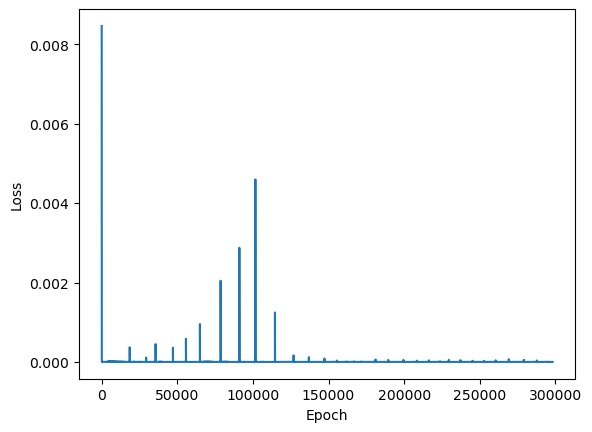

In [23]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,200).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5


epochs = 400000
torch.manual_seed(413)
model = DNN(1,1,32,7)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel3 = model
bestLoss3 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data[:1])
    loss1 = torch.mean((u_pred - u_data[:1])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-2)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss3:
        bestLoss3 = loss.item()
        bestModel3 = model
    if loss.item() < 6e-11: break

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data[:1],u_data[:1],u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn3.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Best loss:  5.997616986386234e-11


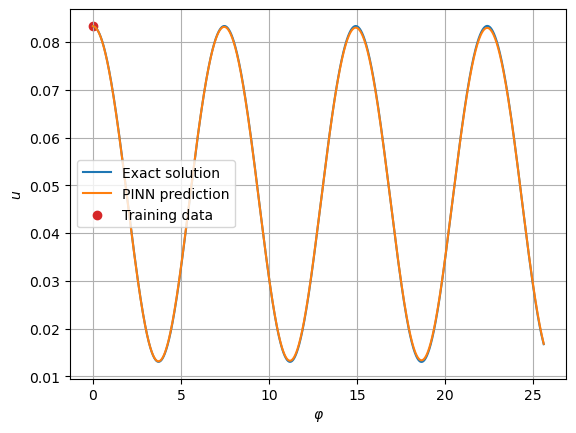

In [24]:
print('Best loss: ', bestLoss3)

# Plot the final result
u_pred = bestModel3(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data[:1], u_data[:1], color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


Best loss:  5.997616986386234e-11


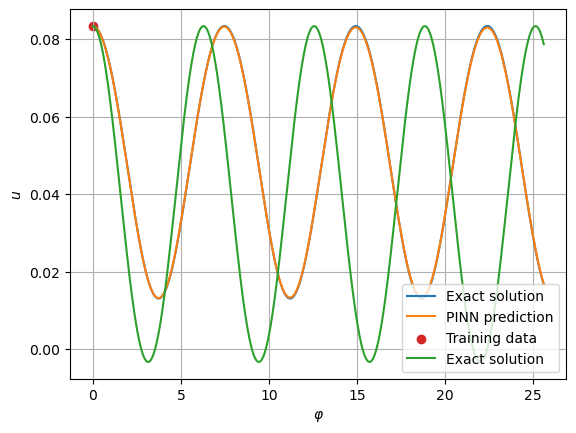

In [34]:
print('Best loss: ', bestLoss3)

# Plot the final result
u_pred = bestModel3(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data[:1], u_data[:1], color="tab:red", label="Training data")
plt.plot(phi, (M/L**2)*(1 + (L**2/(M*12)-1)*np.cos(phi)), label="Exact solution")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()

Epoch:  500  Loss:  2.8332397050689906e-07
Epoch:  1000  Loss:  2.336765163590826e-07
Epoch:  1500  Loss:  2.0004074485768797e-07
Epoch:  2000  Loss:  1.7809426822168462e-07
Epoch:  2500  Loss:  1.646830298795976e-07
Epoch:  3000  Loss:  1.5447868406681664e-07
Epoch:  3500  Loss:  1.4338004916680802e-07
Epoch:  4000  Loss:  1.463902776777104e-07
Epoch:  4500  Loss:  1.4418202454180573e-07
Epoch:  5000  Loss:  1.5607371040005091e-07
Epoch:  5500  Loss:  1.4920566115961265e-07
Epoch:  6000  Loss:  1.4605049614146992e-07
Epoch:  6500  Loss:  1.5576628697999695e-07
Epoch:  7000  Loss:  1.4550694515946816e-07
Epoch:  7500  Loss:  1.5389952068289858e-07
Epoch:  8000  Loss:  1.425102027496905e-07
Epoch:  8500  Loss:  1.499790727166328e-07
Epoch:  9000  Loss:  1.390614414731317e-07
Epoch:  9500  Loss:  1.516324630301824e-07
Epoch:  10000  Loss:  1.3750604921369813e-07
Epoch:  10500  Loss:  1.406526592973023e-07
Epoch:  11000  Loss:  1.4135173387330724e-07
Epoch:  11500  Loss:  1.40702709927609

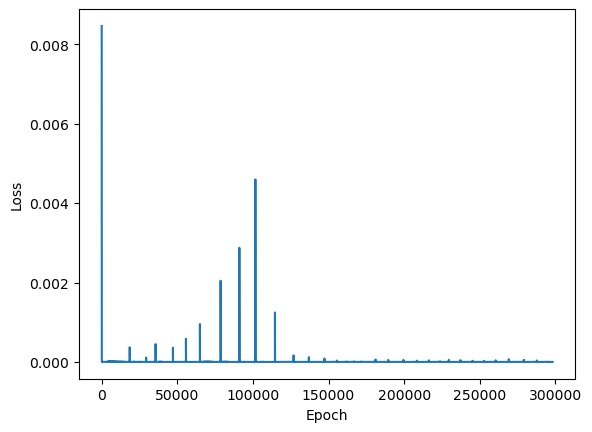

In [39]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,200).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5


epochs = 400000
torch.manual_seed(413)
model = DNN(1,1,32,7)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel4 = model
bestLoss4 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data[:1])
    loss1 = torch.mean((u_pred - u_data[:1])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-2)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss4:
        bestLoss4 = loss.item()
        bestModel4 = model
    if loss.item() < 6e-11: break

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()